# Airbnb EDA

Kaia Lindberg (pkx2ec)



## 5.10 Final Project Ungraded Assignment
At this point in the course, you should be training and evaluating models. Please create a Jupyter Notebook containing a concise summary of your dataset (described in submission instructions).  

At a minimum, the file should include a summary containing:

- Number of records
- Number of columns
- Statistical summary of response variable
- Statistical summary of potential predictor variables (if there are a large number of predictors, select the top 10)
    - Note: Summarize categorical variables with counts and percentages for each level and summarize numerical variables with mean/quantiles/standard deviation.
- Include up to five helpful graphs

In [1]:
# Imports
import os
from pyspark.sql import SparkSession
from pyspark.sql.types import StructType, StructField, StringType, IntegerType, DoubleType
import pyspark.sql.functions as fn



In [34]:
%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import bokeh.charts as chrt
from bokeh.io import output_notebook

output_notebook()

ModuleNotFoundError: No module named 'bokeh.charts'

In [2]:
# Start spark session
spark = SparkSession.builder.getOrCreate()


### Users Dataset

In [3]:
# Define schema for data
schema = StructType() \
      .add("id",StringType(),True) \
      .add("date_account_created",StringType(),True) \
      .add("timestamp_first_active",DoubleType(),True) \
      .add("date_first_booking",StringType(),True) \
      .add("gender",StringType(),True) \
      .add("age",DoubleType(),True) \
      .add("signup_method",StringType(),True) \
      .add("signup_flow",IntegerType(),True) \
      .add("language",StringType(),True) \
      .add("affiliate_channel",StringType(),True) \
      .add("affiliate_provider",StringType(),True) \
      .add("first_affiliate_tracked",StringType(),True) \
      .add("signup_app",StringType(),True) \
      .add("first_device_type",StringType(),True) \
      .add("first_browser",StringType(),True) \
      .add("country_destination",StringType(),True)

In [4]:
# Lists of columns
response_col = "country_destination"
id_col = "id"
categorical_cols = ["gender", "signup_method", "language", 
                    "affiliate_channel", "affiliate_provider", "first_affiliate_tracked",
                    "signup_app", "first_device_type", "first_browser"]
numeric_cols = ["timestamp_first_active", "age", "signup_flow", ]
date_cols = ["date_account_created", "date_first_booking"]


In [5]:
# Read data in json format
df = spark.read.option("header",True).csv("./data/train_users_2.csv", schema)


In [6]:
df.show(2)

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|    2.0090319043255E13|              null|-unknown-|null|     facebook|          0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|


In [7]:
df.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: double (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



In [8]:
# Count number of records
df.count()

213451

In [9]:
print('Count of rows: {0}'.format(df.count()))
print('Count of distinct rows: {0}'.format(df.distinct().count()))

Count of rows: 213451
Count of distinct rows: 213451


In [10]:
# Count number of unique ids

df.agg(
    fn.count('id').alias('count'),
    fn.countDistinct('id').alias('distinct')
).show()

+------+--------+
| count|distinct|
+------+--------+
|213451|  213451|
+------+--------+



Note that the number of distinct ids is the same as the number of rows so there are no duplicate ids.

In [11]:
# Number of columns
len(df.columns)

16

In [12]:
# Percent missing per column
df.agg(*[
    (1 - (fn.count(c) / fn.count('*'))).alias(c + '_missing')
    for c in df.columns
]).show(vertical = True)

-RECORD 0----------------------------------------------
 id_missing                      | 0.0                 
 date_account_created_missing    | 0.0                 
 timestamp_first_active_missing  | 0.0                 
 date_first_booking_missing      | 0.5834734904029496  
 gender_missing                  | 0.0                 
 age_missing                     | 0.412225756731053   
 signup_method_missing           | 0.0                 
 signup_flow_missing             | 0.0                 
 language_missing                | 0.0                 
 affiliate_channel_missing       | 0.0                 
 affiliate_provider_missing      | 0.0                 
 first_affiliate_tracked_missing | 0.02841401539463395 
 signup_app_missing              | 0.0                 
 first_device_type_missing       | 0.0                 
 first_browser_missing           | 0.0                 
 country_destination_missing     | 0.0                 



Overall not too much missing data other than a handful of columns:
- Date of first booking is missing for more than half, but I suspect that these are users that did not make a booking so that is fine. Also this isn't a useful feature anyways because we're going to be using our model to predict before a user makes a booking so we wouldn't know this at inference time anyways. 
- Age has about 40% missing, which is pretty high. Will need to decide what to do with this... drop, fill, impute, etc. 
- First affiliate tracked has some missing values, but not too many so that's fine

In [13]:
# Statistical summary of response variable (count and percentage)

df.groupBy("country_destination") \
  .count() \
  .withColumnRenamed('count', 'Count') \
  .withColumn('Percent', fn.round((fn.col('Count') / df.count()) * 100 , 2)) \
  .show()

+-------------------+------+-------+
|country_destination| Count|Percent|
+-------------------+------+-------+
|                 NL|   762|   0.36|
|                 PT|   217|    0.1|
|                 AU|   539|   0.25|
|                 CA|  1428|   0.67|
|                 GB|  2324|   1.09|
|              other| 10094|   4.73|
|                 DE|  1061|    0.5|
|                 ES|  2249|   1.05|
|                 US| 62376|  29.22|
|                 FR|  5023|   2.35|
|                NDF|124543|  58.35|
|                 IT|  2835|   1.33|
+-------------------+------+-------+



There are 12 different destinations. The most common is NDF, no destination found, meaning that the user did not book a place. The second most common, and most common actual country destination, is the United States. Other is also a common, but pretty broad category. 

In [48]:
# Create binary column (booked place or did not)
df = df.withColumn(
    'booked',
    fn.when((df.country_destination == 'NDF'), 'No')\
    .otherwise('Yes')
)

In [49]:
# Statistical summary of binary response variable (count and percentage)
df.groupBy("booked") \
  .count() \
  .withColumnRenamed('count', 'Count') \
  .withColumn('Percent', fn.round((fn.col('Count') / df.count()) * 100 , 2)) \
  .show()

+------+------+-------+
|booked| Count|Percent|
+------+------+-------+
|    No|124543|  58.35|
|   Yes| 88908|  41.65|
+------+------+-------+



In [15]:
df.select(numeric_cols).show(3)

+----------------------+----+-----------+
|timestamp_first_active| age|signup_flow|
+----------------------+----+-----------+
|    2.0090319043255E13|null|          0|
|    2.0090523174809E13|38.0|          0|
|    2.0090609231247E13|56.0|          3|
+----------------------+----+-----------+
only showing top 3 rows



In [16]:
# Statistical summary of numeric columns
df.select(numeric_cols).summary().show()

+-------+----------------------+------------------+------------------+
|summary|timestamp_first_active|               age|       signup_flow|
+-------+----------------------+------------------+------------------+
|  count|                213451|            125461|            213451|
|   mean|  2.013085041736745...| 49.66833517985669|3.2673868944160485|
| stddev|   9.253717046788992E9|155.66661183021571|  7.63770686943505|
|    min|    2.0090319043255E13|               1.0|                 0|
|    25%|     2.012122504391E13|              28.0|                 0|
|    50%|    2.0130911053924E13|              34.0|                 0|
|    75%|    2.0140306074825E13|              43.0|                 0|
|    max|    2.0140630235824E13|            2014.0|                25|
+-------+----------------------+------------------+------------------+



Note illogical min age of 1 and max age of 2014.

Signup flow is numeric, but according to dataset description on kaggle signup_flow is the page a user came to signup up from. Not sure what this column means

In [ ]:
# Replace age with nan if outside reasonable range
df = df.withColumn(
    'age_new', \
    fn.when((df.age > 100) | (df.age < 16), None)\
    .otherwise(df.age)
)

In [ ]:
df.select('age', 'age_new').summary().show()

In [17]:
for col in categorical_cols:
    print(col)
    df.groupBy(col) \
          .count() \
          .withColumnRenamed('count', 'Count') \
          .withColumn('Percent', fn.round((fn.col('Count') / df.count()) * 100 , 2)) \
          .sort(fn.desc('Count')) \
          .show()

gender
+---------+-----+-------+
|   gender|Count|Percent|
+---------+-----+-------+
|-unknown-|95688|  44.83|
|   FEMALE|63041|  29.53|
|     MALE|54440|   25.5|
|    OTHER|  282|   0.13|
+---------+-----+-------+

signup_method
+-------------+------+-------+
|signup_method| Count|Percent|
+-------------+------+-------+
|        basic|152897|  71.63|
|     facebook| 60008|  28.11|
|       google|   546|   0.26|
+-------------+------+-------+

language
+--------+------+-------+
|language| Count|Percent|
+--------+------+-------+
|      en|206314|  96.66|
|      zh|  1632|   0.76|
|      fr|  1172|   0.55|
|      es|   915|   0.43|
|      ko|   747|   0.35|
|      de|   732|   0.34|
|      it|   514|   0.24|
|      ru|   389|   0.18|
|      pt|   240|   0.11|
|      ja|   225|   0.11|
|      sv|   122|   0.06|
|      nl|    97|   0.05|
|      tr|    64|   0.03|
|      da|    58|   0.03|
|      pl|    54|   0.03|
|      cs|    32|   0.01|
|      no|    30|   0.01|
|      th|    24|   0.0

A few observations: 
- Large number unknown gender
- Majority of language is english, but a lot of other smaller ones. May want to group some smaller ones into other

## Sessions Dataset

In [18]:
# Define schema for data
schema_sessions = StructType() \
      .add("user_id",StringType(),True) \
      .add("action",StringType(),True) \
      .add("action_type",StringType(),True) \
      .add("action_detail",StringType(),True) \
      .add("device_type",StringType(),True) \
      .add("secs_elapsed",DoubleType(),True)

In [19]:
# Read data in json format
df_sessions = spark.read.option("header",True) \
    .csv("./data/sessions.csv", schema_sessions)


In [20]:
df_sessions.show(2)

+----------+--------------+-----------+-------------------+---------------+------------+
|   user_id|        action|action_type|      action_detail|    device_type|secs_elapsed|
+----------+--------------+-----------+-------------------+---------------+------------+
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       319.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     67753.0|
+----------+--------------+-----------+-------------------+---------------+------------+
only showing top 2 rows



In [21]:
df_sessions.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)



In [22]:
# Count number of records
df_sessions.count()

10567737

In [23]:
print('Count of rows: {0}'.format(df_sessions.count()))
print('Count of distinct rows: {0}'.format(df_sessions.distinct().count()))

Count of rows: 10567737
Count of distinct rows: 10315201


Not all rows are unique, but given this dataset I think that is reasonable because a given user could do the same action multiple times. 

In [24]:
# Count number of unique ids
df_sessions.agg(
    fn.count('user_id').alias('Count'),
    fn.countDistinct('user_id').alias('Distinct Count')
).show()

+--------+--------------+
|   Count|Distinct Count|
+--------+--------------+
|10533241|        135483|
+--------+--------------+



Not concerning that there are fewer distinct ids than total rows in this dataset because a given user could have multiple sessions. 

However, important to note that the train_users data had more unique ids than this dataset (213451 versus 135483) so we do not have session data for all users. I wonder whether this is meaningful... like if we don't have session data then the user wasn't active.... or whether it is just missing/incomplete data. 

In [25]:
# Caclulate frequency of different actions
for col in ['action', 'action_type', 'action_detail']:
    print(col)
    df_sessions.groupBy(col) \
          .count() \
          .withColumnRenamed('count', 'Count') \
          .withColumn('Percent', fn.round((fn.col('Count') / df_sessions.count()) * 100 , 2)) \
          .sort(fn.desc('Count')) \
          .show(truncate = False)

action
+---------------------+-------+-------+
|action               |Count  |Percent|
+---------------------+-------+-------+
|show                 |2768278|26.2   |
|index                |843699 |7.98   |
|search_results       |725226 |6.86   |
|personalize          |706824 |6.69   |
|search               |536057 |5.07   |
|ajax_refresh_subtotal|487744 |4.62   |
|update               |365130 |3.46   |
|similar_listings     |364624 |3.45   |
|social_connections   |339000 |3.21   |
|reviews              |320591 |3.03   |
|active               |188036 |1.78   |
|similar_listings_v2  |168788 |1.6    |
|lookup               |162041 |1.53   |
|create               |155887 |1.48   |
|dashboard            |152952 |1.45   |
|header_userpic       |141830 |1.34   |
|collections          |124417 |1.18   |
|edit                 |109083 |1.03   |
|campaigns            |105028 |0.99   |
|track_page_view      |81117  |0.77   |
+---------------------+-------+-------+
only showing top 20 rows

action_

There are a lot of different actions... not sure the best way to aggregate these to the user level. 

To start I think I'll just try a couple:
- Total time elapsed (sum secs_elapsed for each user)
- Number of actions (count of records in sessions data for each user... probably correlated with time elapsed though)
- Number of different actions
    
Future possiblility: maybe use NLP techniques to extract info from the action details? Like maybe turn these into a list of actions then use like TF-IDF or something to look at frequency of these different actions without doing it manually?

In [26]:
# Aggregate some session data to user level

session_agg = df_sessions.groupby('user_id').agg(
    fn.sum('secs_elapsed').alias('total_time_elapsed'),
    fn.count('action').alias('total_num_actions'),
    fn.countDistinct('action').alias('num_unique_actions'),
    fn.count('action_type').alias('total_num_action_types'),
    fn.countDistinct('action_type').alias('num_unique_action_types'),
    fn.count('action_detail').alias('total_num_action_details'),
    fn.countDistinct('action_detail').alias('num_unique_action_det')
)

In [27]:
session_agg.show(3)

+----------+------------------+-----------------+------------------+----------------------+-----------------------+------------------------+---------------------+
|   user_id|total_time_elapsed|total_num_actions|num_unique_actions|total_num_action_types|num_unique_action_types|total_num_action_details|num_unique_action_det|
+----------+------------------+-----------------+------------------+----------------------+-----------------------+------------------------+---------------------+
|funlgmcmr3|           54747.0|               10|                 6|                     9|                      5|                       9|                    7|
|e2zoe02zd5|          642272.0|               64|                11|                    50|                      5|                      50|                    8|
|f0cnhta47g|         1338892.0|              167|                21|                   123|                      5|                     123|                   14|
+----------+----------

In [28]:
session_agg.filter(df_sessions.user_id == 'd1mm9tcy42').show(vertical = True)

-RECORD 0------------------------------
 user_id                  | d1mm9tcy42 
 total_time_elapsed       | 3427529.0  
 total_num_actions        | 126        
 num_unique_actions       | 16         
 total_num_action_types   | 90         
 num_unique_action_types  | 6          
 total_num_action_details | 90         
 num_unique_action_det    | 9          



In [29]:
# Count number of unique ids
session_agg.agg(
    fn.count('user_id').alias('Count'),
    fn.countDistinct('user_id').alias('Distinct Count')
).show()

+------+--------------+
| Count|Distinct Count|
+------+--------------+
|135483|        135483|
+------+--------------+



## Join Aggregated Session Data with User Data

In [30]:
# Check counts before join
df.agg(
    fn.count('id').alias('Count'),
    fn.countDistinct('id').alias('Distinct Count')
).show()

+------+--------------+
| Count|Distinct Count|
+------+--------------+
|213451|        213451|
+------+--------------+



In [31]:
# Join datasets - use left join to keep as user data
df = df.join(session_agg,df.id ==  session_agg.user_id,"left")

In [32]:
# Check counts after join
df.agg(
    fn.count('id').alias('Count'),
    fn.countDistinct('id').alias('Distinct Count')
).show()

+------+--------------+
| Count|Distinct Count|
+------+--------------+
|213451|        213451|
+------+--------------+



In [47]:
df.show(1, vertical = True)

-RECORD 0--------------------------------------
 id                       | 01r3iatdvv         
 date_account_created     | 2014-02-11         
 timestamp_first_active   | 2.0140211202128E13 
 date_first_booking       | 2014-02-12         
 gender                   | -unknown-          
 age                      | null               
 signup_method            | basic              
 signup_flow              | 0                  
 language                 | en                 
 affiliate_channel        | direct             
 affiliate_provider       | direct             
 first_affiliate_tracked  | untracked          
 signup_app               | Web                
 first_device_type        | Mac Desktop        
 first_browser            | Chrome             
 country_destination      | US                 
 user_id                  | 01r3iatdvv         
 total_time_elapsed       | 813485.0           
 total_num_actions        | 27                 
 num_unique_actions       | 13          

## Data Visualization

Text(0.5, 1.0, "Histogram of 'age'")

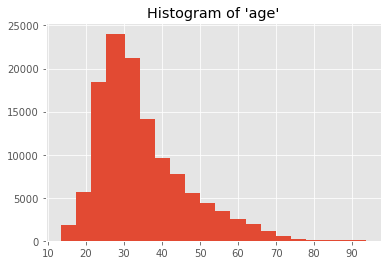

In [45]:
# Histogram of age
hists = df.select('age_new').rdd.flatMap(
    lambda row: row
).histogram(20)

data = {
    'bins': hists[0][:-1],
    'freq': hists[1]
}
plt.bar(data['bins'], data['freq'], width=5)
plt.title('Histogram of Age')

<AxesSubplot:xlabel='total_time_elapsed', ylabel='booked'>

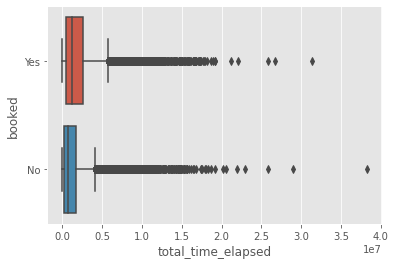

In [85]:
import seaborn as sns
temp_data = df.select('total_time_elapsed', 'booked').toPandas()
sns.boxplot(data=temp_data, x="total_time_elapsed", y="booked")
plt.title('Distribution of Total Session Time by Booked')

Clearly a large number of outliers in total elapsed time, but looks like those that booked tend to have slightly higher elapsed time that those that didn't. 

Text(0.5, 1.0, 'Distribution of Gender by Booked')

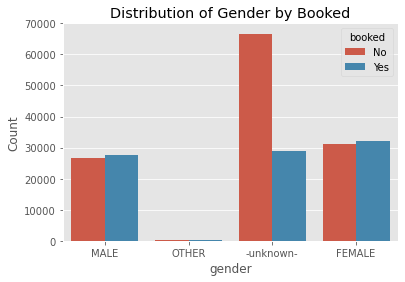

In [91]:
temp_data = df.groupby('booked', 'gender').agg(fn.count('id').alias('Count')).toPandas()
sns.barplot(data=temp_data, x="gender", y="Count", hue = 'booked')
plt.title('Distribution of Gender by Booked')

The majority of unknown genders did not book a rental.... possibly an indicator that they did not spend as much time updating the information in their profile.